In [18]:
import sklearn
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score,make_scorer
from ConstructDatatset import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from TotalCalculation import *
from preprocessing import *
from ClassPrediction import *

In [19]:
df1 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_sobel\Dataset_06_2024')
df2 = Builddataset().concateDataset(folder_name = r'C:\Users\ASUS\Documents\NARIT_internship_data\CSV_dataset_sobel\Dataset_12_2023')

In [20]:
date1 = []
for i in df1.index.tolist():
    date1.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df1['Time'] = date1
date2 = []
for i in df2.index.tolist():
    date2.append(timeConvertion().ticks_to_datetime(i,time_zone=7))
df2['Time'] = date2


In [21]:
df1['Time (decimal)'] = df1['Time'].dt.hour+df1['Time'].dt.minute/60
df2['Time (decimal)'] = df2['Time'].dt.hour+df2['Time'].dt.minute/60

name_y = str('Blue channel')
name_x = np.arange(len(df))
dintr = np.gradient(df['Blue channel'])
dintb = np.gradient(df['Red channel'])

plt.figure(figsize=(30,20))
sns.lineplot(data=df,x=name_x,y=df[name_y],c='blue')
sns.lineplot(data=df,x=name_x,y=df['Red channel'],c='green')
sns.lineplot(data=df,x=name_x,y=df['intensity'])
plt.plot(dintr)
plt.plot(dintb,c='r')

df

In [22]:
start_date = '2024-01-01'
end_date = str(df1['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion().time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise1,sunset1 = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

start_date = '2023-01-01'
end_date = str(df2['Time'].tolist()[1])
location = [18.849417,98.9538]
days = timeConvertion().time_duration(start_date,end_date,include_end_date=True).days

LSTM = SunPosition.LSTM(time_zone_offset=7)
EoT = SunPosition.calculate_EoT(day=days)
TC = SunPosition.TimeCorrectionFactor(Longitude=location[1],LSTM=LSTM,EoT=EoT)
dec = SunPosition.declination(day=days)
suntime = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)
sunrise2,sunset2 = SunPosition.DaytimeInfo(latitude=location[0],declination=dec,TC=TC)

In [23]:
df1 = Builddataset().DayNightSplit(suntime=[sunrise1,sunset1],Mode='day',dataframe=df1)
df2 = Builddataset().DayNightSplit(suntime=[sunrise2,sunset2],Mode='day',dataframe=df2)

df = pd.concat([df1,df2])

In [24]:
x = df.drop(columns=['Time (decimal)','Time','correlation','Blue channel','Red channel','intensity'])

dataset = list(x.itertuples(index=False,name=None))
dataset = np.array(dataset)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20245 entries, 638535703952838218 to 638377154550673052
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   contrast        20245 non-null  float64       
 1   dissimilarity   20245 non-null  float64       
 2   homogeneity     20245 non-null  float64       
 3   energy          20245 non-null  float64       
 4   correlation     20245 non-null  float64       
 5   ASM             20245 non-null  float64       
 6   intensity       20245 non-null  float64       
 7   Red channel     20245 non-null  float64       
 8   Blue channel    20245 non-null  float64       
 9   Time            20245 non-null  datetime64[ns]
 10  Time (decimal)  20245 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 1.9 MB


<Axes: >

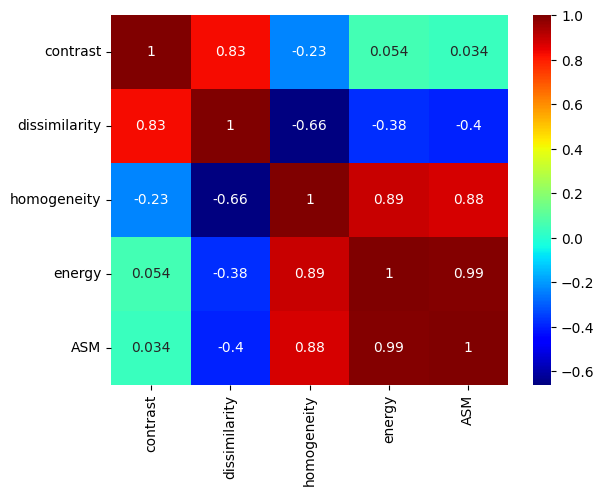

In [26]:
sns.heatmap(data=x.corr(),cmap='jet',annot=True)

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
np.random.seed(42)
kmeans = KMeans(init='k-means++', n_clusters=5, n_init='auto', random_state=42, tol=1e-05,algorithm='lloyd')
minik = MiniBatchKMeans(n_clusters=5,batch_size=1036, max_no_improvement=30, tol=1e-4, random_state=42, init='k-means++' ,n_init=10, max_iter=300 ,reassignment_ratio=0.001)
#af = AffinityPropagation(damping=0.95, max_iter=500, convergence_iter=20, preference=-50, affinity='euclidean')
GMM = GaussianMixture(n_components=7, tol=1e-4, init_params='kmeans',covariance_type='full', max_iter=500, random_state=42, n_init=10)
labels = GMM.fit_predict(dataset)
labels_kmean = kmeans.fit_predict(dataset)
labels_minik = minik.fit_predict(dataset)
#labels_af = af.fit_predict(dataset)

In [28]:
#df.loc[:, 'Label_GMM'] = labels
#df.loc[:, 'Label_Kmean'] = labels_kmean
#df.loc[:, 'Label_AF'] = labels_af

<Axes: xlabel='contrast', ylabel='dissimilarity'>

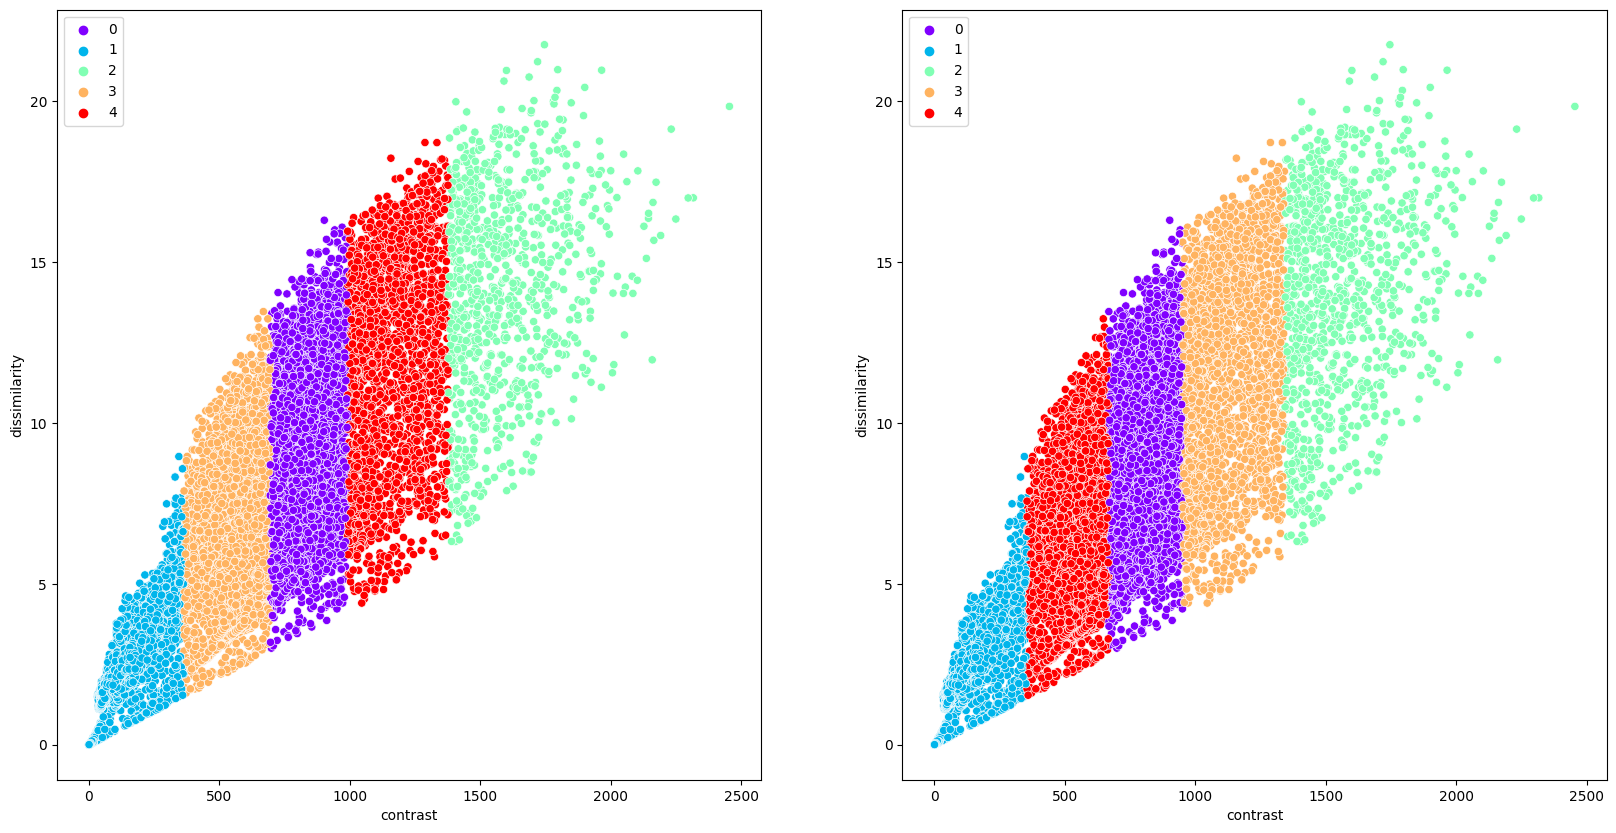

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.scatterplot(data=df,x=df['contrast'],y=df['dissimilarity'],hue=labels_minik,palette='rainbow')
plt.subplot(1,2,2)
sns.scatterplot(data=df,x=df['contrast'],y=df['dissimilarity'],hue=labels_kmean,palette='rainbow')

In [30]:
print(silhouette_score(dataset,labels_kmean))
print(silhouette_score(dataset,labels_minik))
#print(silhouette_score(dataset,labels))

0.5837869659230307
0.5880847262577296


from sklearn.model_selection import GridSearchCV

def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)
# Example adjustment for KMeans
param_grid_kmeans = {
    'tol' : [1e-4,1e-5,1e-6],
    'n_clusters': [5, 7, 9, 11],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 'auto'],
    'max_iter': [300, 500, 700],
    'batch_size': [536,1036,1536]
}
grid_search_kmeans = GridSearchCV(MiniBatchKMeans(random_state=42), param_grid_kmeans, cv=5, scoring=silhouette_scorer)
grid_search_kmeans.fit(dataset)  # X is your data

best_kmeans = grid_search_kmeans.best_estimator_


In [31]:
print(best_kmeans)

MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=10,
                random_state=42, tol=1e-06)


print(best_kmeans)
#KMeans(n_clusters=5, n_init=20, random_state=42, tol=1e-05) : sobel
#KMeans(init='k-means++', n_clusters=5, n_init=20, random_state=42, tol=1e-05,algorithm='lloyd')

#MiniBatchKMeans(max_iter=300, n_clusters=5, n_init=10, random_state=42,tol=0.0001) : sobel
#MiniBatchKMeans(n_clusters=5,batch_size=1500, max_no_improvement=30, tol=1e-4, random_state=42, init='k-means++' ,n_init=10, max_iter=500 ,reassignment_ratio=0.001)
#--normal glcm---
#MiniBatchKMeans(batch_size=500, max_iter=300, n_clusters=5, n_init=20,random_state=42, tol=1e-05) \\ same
#KMeans(n_clusters=5, n_init='auto', random_state=42)
#---------New dataset--------#
#KMeans(n_clusters=5, n_init='auto', random_state=42)
#MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=20,random_state=42, tol=0.0001)
#KMeans(algorithm='elkan', n_clusters=5, n_init=10, random_state=42)
#MiniBatchKMeans(batch_size=1036, max_iter=300, n_clusters=5, n_init=10,random_state=42, tol=1e-06)

import pickle 

with open('af_model_1.pkl','wb') as f:
    pickle.dump(af,f)

In [ ]:
import pickle
with open('gmm_model_7.pkl', 'wb') as f:
    pickle.dump(GMM, f)
with open('kmean_model_7.pkl', 'wb') as f:
    pickle.dump(kmeans, f)
with open('miniBkmean_model_7.pkl', 'wb') as f:
    pickle.dump(minik, f)

from preprocessing import image
image_list = image.getFilename(r'C:\Users\ASUS\Documents\NARIT_internship_data\Test_folder')

filetime = []
for file in image_list:
    filetime.append(int(os.path.splitext(os.path.basename(file))[0]))


viz = visualizer()
number = 1
source_folder = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-12'
destination_folder = r'C:\Users\ASUS\Documents\NARIT_internship_2024\Tester'

viz.copy_matching_files(df=viz.match_label(df=df,number=number), source_folder=source_folder, destination_folder=destination_folder)

pred = prediction()
path = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-09\638534868144584540.png'
pred_1,pred_2,cloud_percentage,sky_status,final = pred.total_prediction(image_path=path,mask_path='mask_delete_5.png',crop_size=570,kmeans=kmeans,GMM=GMM,df=df)

mask = cv2.imread('mask_delete_5.png',cv2.IMREAD_GRAYSCALE)
mask = crop_center(img=mask,crop_size=570)
img,name = load_single_image(path=path,crop_size=570,mask=mask,apply_crop_sun=False)
image,value,RB = pred.RBsingle(input=img,dataframe=df)
cloud_ratio = pred.CloudRatio(image=img,mask=mask)

import requests
import cv2
import numpy as np
import hashlib
import time

def get_image_hash(image_data):
    return hashlib.md5(image_data).hexdigest()

image_url = "http://weather.narit.or.th/images/allskyimage/ASTROPARK/2024-08-19"
previous_hash = None

while True:
    # Fetch the image from the web
    response = requests.get(image_url)
    if response.status_code == 200:
        # Get the current hash of the image
        current_hash = get_image_hash(response.content)
        
        # Compare with the previous hash
        if current_hash != previous_hash:
            # The image has changed
            print("Image has changed, updating display...")
            image_array = np.frombuffer(response.content, np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            cv2.imshow('Auto-Updated Image', image)
            
            # Update the previous hash
            previous_hash = current_hash
            
            # Wait for 1 second to avoid rapid flickering
            if cv2.waitKey(1000) & 0xFF == ord('q'):
                break
        else:
            print("No change detected.")
    
    # Check every 10 seconds for a change
    time.sleep(10)
    cv2.destroyAllWindows()


sns.scatterplot(data=df,x=df['contrast'],y=df['homogeneity'],hue=labels_kmean)

sns.heatmap(df.corr(),annot=True)